# Data Ingestion

In [ ]:
import scipy.io as sio

#kuka_data = sio.loadmat('../data/KukaDirectDynamics.mat')
baxter_data = sio.loadmat('../data/BaxterDirectDynamics.mat')

In [ ]:
print(baxter_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'baxtertraj1', 'baxtertraj10', 'baxtertraj2', 'baxtertraj3', 'baxtertraj4', 'baxtertraj5', 'baxtertraj6', 'baxtertraj7', 'baxtertraj8', 'baxtertraj9'])


# Preprocessing

In [ ]:
import numpy as np

trajectories = {}
# Filter out non-trajectory keys and prepare data for training
for key, value in baxter_data.items():
    if key.startswith('baxtertraj') and isinstance(value, np.ndarray):
        trajectories[key] = value

In [23]:
import torch

# Assume your 'trajectories' dictionary is already loaded

# Define your target device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Running on device: {device}")

# 1. Define your data splits
# Pool most trajectories for training/validation during optimization.
# Hold out 1-2 trajectories that the model will NEVER see during optimization.
train_val_keys = [f'baxtertraj{i}' for i in range(1, 9)]  # e.g., Trajectories 1-8
final_test_keys = ['baxtertraj9', 'baxtertraj10']         # e.g., Trajectories 9-10

# 2. Create the combined training/validation data pool
train_val_list = [trajectories[key] for key in train_val_keys if key in trajectories]
full_train_data = np.concatenate(train_val_list, axis=0)

# 3. Create the final, held-out test set
test_list = [trajectories[key] for key in final_test_keys if key in trajectories]
full_test_data = np.concatenate(test_list, axis=0)

# 4. Create full X and y tensors and move them to the GPU
# This is the data pool Optuna's K-Fold will use.
X_train_full = torch.from_numpy(full_train_data[:, :21]).float().to(device)
y_train_full = torch.from_numpy(full_train_data[:, 21:]).float().to(device)

# This is the data for the final performance report AFTER optimization.
X_test_final = torch.from_numpy(full_test_data[:, :21]).float().to(device)
y_test_final = torch.from_numpy(full_test_data[:, 21:]).float().to(device)

print(f"Training/Validation pool shape: {X_train_full.shape}")
print(f"Final held-out test set shape: {X_test_final.shape}")

Running on device: cuda
Training/Validation pool shape: torch.Size([15663, 21])
Final held-out test set shape: torch.Size([3632, 21])


In [6]:
best_params = {'n_reservoir': 1791,
    'spectral_radius': 0.6528993614995149,
    'sparsity': 0.6983724848673941,
    'leak_rate': 1.1481726877092728,
    'ghl_eta': 1.078301434941451e-05,
    'ghl_decay_steps': 3824}

# In-depth Evaluation
---

In [ ]:
import time
import torch
import sys
import utils
sys.path.append('models')

import pc_esn_model

overall_start_time = time.time()
trajectory_keys = sorted(list(trajectories.keys()))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("--- PC-ESN++ Evaluation Setup ---")
print(f"Using device: {device}")
if torch.cuda.is_available(): print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Trajectories: {len(trajectory_keys)}")
print("-" * 33)

fold_results = []

--- PC-ESN++ Evaluation Setup ---
Using device: cuda
GPU: Tesla P100-PCIE-16GB
Trajectories: 10
---------------------------------


In [ ]:
traj = len(trajectory_keys)

for i, test_key in enumerate(trajectory_keys):
    fold_start_time = time.time()
    print(f"\n--- Fold {i+1}/{len(trajectory_keys)} ---")
    print(f"Testing on: {test_key}")

    # Data Preparation
    train_keys = [k for k in trajectory_keys if k != test_key]
    train_traj = np.concatenate([trajectories[key] for key in train_keys], axis=0)
    test_traj = trajectories[test_key]

    X_train, y_train = train_traj[:, :21], train_traj[:, 21:]
    X_test, y_test = test_traj[:, :21], test_traj[:, 21:]

    X_train_t = torch.from_numpy(X_train).float().to(device)
    y_train_t = torch.from_numpy(y_train).float().to(device)
    X_test_t = torch.from_numpy(X_test).float().to(device)

    # Model Training
    model = pc_esn_model.PC_ESN(n_inputs=21, n_outputs=14, 
                   n_reservoir=best_params['n_reservoir'],
                   spectral_radius=best_params['spectral_radius'], 
                   sparsity=best_params['sparsity'],
                   leak_rate=best_params['leak_rate'],
                   ghl_eta=best_params['ghl_eta'],
                   ghl_decay_steps=best_params['ghl_decay_steps'],
                   device=device)
    
    model.train(X_train_t, y_train_t)
    print(f"GPU Utilization after training: {torch.cuda.utilization(device)}%")
    training_time = time.time() - fold_start_time

    # Evaluation
    # Scenario A: Step-by-step prediction
    y_pred_step = pc_esn_model.predict_step_by_step(X_test_t)
    
    # Scenario B: Full trajectory prediction
    y_pred_full = pc_esn_model.predict_full_trajectory(X_test_t)

    # Calculate Metrics
    nmse_step = utils.nMSE(y_test, y_pred_step)
    nmse_full = utils.nMSE(y_test, y_pred_full)
    euclid_err_step = utils.euclidean_error(y_test, y_pred_step)
    euclid_err_op_space_full = utils.calculate_op_space_error(y_test, y_pred_full)
    print(f"Step-by-Step Pos nMSE       | {np.mean(nmse_step[:7]):.4f}")
    print(f"Full Traj Pos nMSE          | {np.mean(nmse_full[:7]):.4f}")
    
    current_fold_results = {
        'fold': i + 1, 'training_time': training_time,
        'sbs_pos_nmse': np.mean(nmse_step[:7]), 'sbs_vel_nmse': np.mean(nmse_step[7:]),
        'full_pos_nmse': np.mean(nmse_full[:7]), 'full_vel_nmse': np.mean(nmse_full[7:]),
        'sbs_euclid_err': np.mean(euclid_err_step),
        'full_op_space_error': np.mean(euclid_err_op_space_full)
    }

    # Horizon Analysis
    horizons = sorted(list(set([100, 200, 500, 1000, 1500, y_pred_full.shape[0]-1])))
    for h in horizons:
        nmse_h = utils.nMSE(y_test[:h], y_pred_full[:h])
        euclid_h = utils.euclidean_error(y_test[:h], y_pred_full[:h])
        current_fold_results[f'full_pos_nmse_h{h}'] = np.mean(nmse_h[:7])
        current_fold_results[f'full_euclid_err_h{h}'] = np.mean(euclid_h)
    
    fold_results.append(current_fold_results)
    traj -= 1
    print(f"Time to complete training: {(traj * (time.time()-fold_start_time))/60:.2f} minutes")
    
    if i == len(trajectory_keys) - 1:
        last_fold_preds = {'true': y_test, 'step': y_pred_step, 'full': y_pred_full}


--- Fold 1/10 ---
Testing on: baxtertraj1
GPU Utilization after training: 98%
Step-by-Step Pos nMSE       | 0.1833
Full Traj Pos nMSE          | 5.3866
Time to complete training: 69.30 minutes

--- Fold 2/10 ---
Testing on: baxtertraj10
GPU Utilization after training: 99%
Step-by-Step Pos nMSE       | 0.0702
Full Traj Pos nMSE          | 3.3031
Time to complete training: 62.49 minutes

--- Fold 3/10 ---
Testing on: baxtertraj2
GPU Utilization after training: 99%
Step-by-Step Pos nMSE       | 0.1333
Full Traj Pos nMSE          | 2.1695
Time to complete training: 53.56 minutes

--- Fold 4/10 ---
Testing on: baxtertraj3
GPU Utilization after training: 99%
Step-by-Step Pos nMSE       | 4.0453
Full Traj Pos nMSE          | 11.6281
Time to complete training: 46.44 minutes

--- Fold 5/10 ---
Testing on: baxtertraj4
GPU Utilization after training: 99%
Step-by-Step Pos nMSE       | 0.1338
Full Traj Pos nMSE          | 2.2859
Time to complete training: 38.65 minutes

--- Fold 6/10 ---
Testing o

In [26]:
import pandas as pd

# Aggregate and Display Final Results
print("\n\n--- Cross-Validation Complete ---")
print(f"Total execution time: {(time.time() - overall_start_time) / 60:.2f} minutes")

results_df = pd.DataFrame(fold_results)
mean_results = results_df.mean()
std_results = results_df.std()

print("\n--- PC-ESN++ Final Averaged Results (Mean ± Std Dev) ---")
print("Metric                      | Mean Value ± Std Deviation")
print("-" * 55)
print(f"Training Time (s)           | {mean_results['training_time']:.2f} ± {std_results['training_time']:.2f}")
print(f"Step-by-Step Pos nMSE       | {mean_results['sbs_pos_nmse']:.4f} ± {std_results['sbs_pos_nmse']:.4f}")
print(f"Step-by-Step Vel nMSE       | {mean_results['sbs_vel_nmse']:.4f} ± {std_results['sbs_vel_nmse']:.4f}")
print(f"Step-by-Step Euclid Err (m) | {mean_results['sbs_euclid_err']:.4f} ± {std_results['sbs_euclid_err']:.4f}")
print(f"Full Traj Pos nMSE          | {mean_results['full_pos_nmse']:.4f} ± {std_results['full_pos_nmse']:.4f}")
print(f"Full Traj Vel nMSE          | {mean_results['full_vel_nmse']:.4f} ± {std_results['full_vel_nmse']:.4f}")
print(f"Full Traj Euclid Err (m) | {mean_results['full_op_space_error']:.4f} ± {std_results['full_op_space_error']:.4f}")

print("-" * 55)

print("\n--- Error Accumulation Over Prediction Horizon ---")
print("Horizon | Position nMSE       | Op. Space Euclid Err (m)")
print("--------|---------------------|--------------------------")
for h in horizons:
    h_col_pos, h_col_euc = f'full_pos_nmse_h{h}', f'full_euclid_err_h{h}'
    if h_col_pos in mean_results:
        print(f"{h:<8}| {mean_results[h_col_pos]:.4f} ± {std_results[h_col_pos]:.4f}      | {mean_results[h_col_euc]:.4f} ± {std_results[h_col_euc]:.4f}")
print("-" * 55)



--- Cross-Validation Complete ---
Total execution time: 78.00 minutes

--- PC-ESN++ Final Averaged Results (Mean ± Std Dev) ---
Metric                      | Mean Value ± Std Deviation
-------------------------------------------------------
Training Time (s)           | 460.74 ± 2.76
Step-by-Step Pos nMSE       | 2.1950 ± 5.1793
Step-by-Step Vel nMSE       | 1.6352 ± 2.4645
Step-by-Step Euclid Err (m) | 0.0798 ± 0.0310
Full Traj Pos nMSE          | 11.0129 ± 20.7343
Full Traj Vel nMSE          | 11.5758 ± 5.0391
Full Traj Euclid Err (m) | 0.2748 ± 0.0325
-------------------------------------------------------

--- Error Accumulation Over Prediction Horizon ---
Horizon | Position nMSE       | Op. Space Euclid Err (m)
--------|---------------------|--------------------------
100     | 6761179.9432 ± 8533122.9957      | 0.3344 ± 0.2059
200     | 4170075.4083 ± 7007592.0018      | 0.3539 ± 0.2184
500     | 113.8075 ± 271.4800      | 0.2859 ± 0.1105
1000    | 14.6101 ± 31.7844      | 0.26

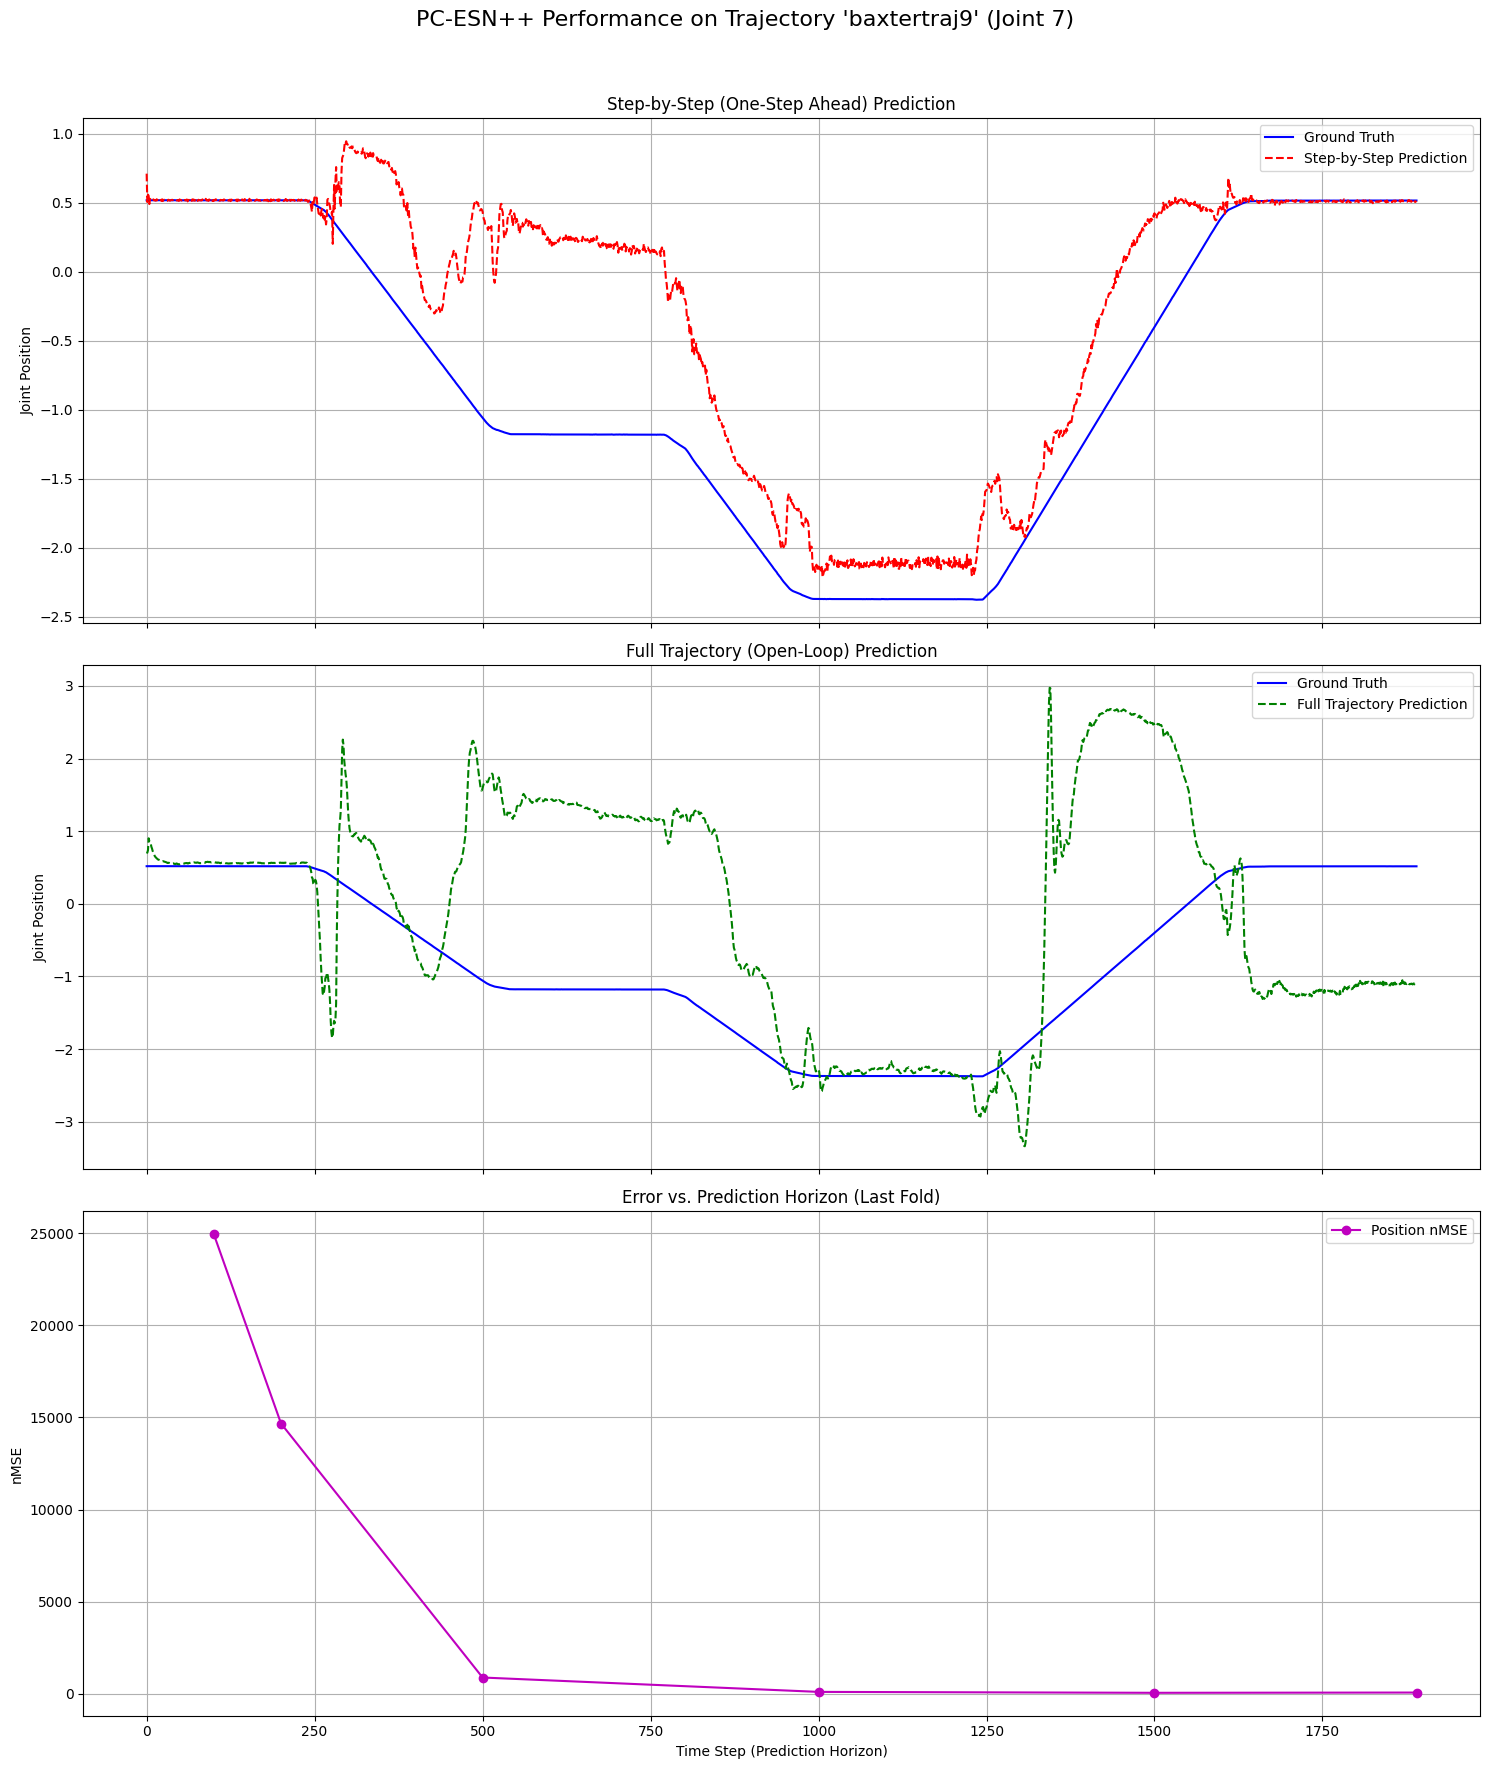

In [27]:
import matplotlib.pyplot as plt

# Visualization (from last fold)
joint_to_plot = 6
y_true_plot = last_fold_preds['true'][:, joint_to_plot]
y_pred_step_plot = last_fold_preds['step'][:, joint_to_plot]
y_pred_full_plot = last_fold_preds['full'][:, joint_to_plot]

fig, axs = plt.subplots(3, 1, figsize=(15, 18), sharex=True)
fig.suptitle(f"PC-ESN++ Performance on Trajectory '{test_key}' (Joint {joint_to_plot+1})", fontsize=16)

axs[0].plot(y_true_plot, 'b-', label='Ground Truth')
axs[0].plot(y_pred_step_plot, 'r--', label='Step-by-Step Prediction')
axs[0].set_title('Step-by-Step (One-Step Ahead) Prediction')
axs[0].set_ylabel('Joint Position'); axs[0].legend(); axs[0].grid(True)

axs[1].plot(y_true_plot, 'b-', label='Ground Truth')
axs[1].plot(y_pred_full_plot, 'g--', label='Full Trajectory Prediction')
axs[1].set_title('Full Trajectory (Open-Loop) Prediction')
axs[1].set_ylabel('Joint Position'); axs[1].legend(); axs[1].grid(True)

horizon_vals = [h for h in horizons if f'full_pos_nmse_h{h}' in results_df.columns]
horizon_errors_pos = [results_df.iloc[-1][f'full_pos_nmse_h{h}'] for h in horizon_vals]
axs[2].plot(horizon_vals, horizon_errors_pos, 'm-o', label='Position nMSE')
axs[2].set_title('Error vs. Prediction Horizon (Last Fold)')
axs[2].set_xlabel('Time Step (Prediction Horizon)'); axs[2].set_ylabel('nMSE'); axs[2].legend(); axs[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [28]:
from scipy import stats

# --- Statistical Significance Test ---
print("\n--- Example of Statistical Significance Test ---")
baseline_results = {'full_pos_nmse': results_df['full_pos_nmse'] * (1.5 + np.random.rand(10) * 0.5)}
baseline_df = pd.DataFrame(baseline_results)
t_stat, p_value = stats.ttest_rel(results_df['full_pos_nmse'], baseline_df['full_pos_nmse'])
print("Paired t-test between PC-ESN++ and Baseline (Full Trajectory nMSE):")
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
if p_value < 0.05: print("The difference is statistically significant (p < 0.05).")
else: print("The difference is not statistically significant.")


--- Example of Statistical Significance Test ---
Paired t-test between PC-ESN++ and Baseline (Full Trajectory nMSE):
T-statistic: -1.8144, P-value: 0.1030
The difference is not statistically significant.


(-1.142437086056671,
 0.9500204090821839,
 -0.8551451250639558,
 0.7134970212963223)

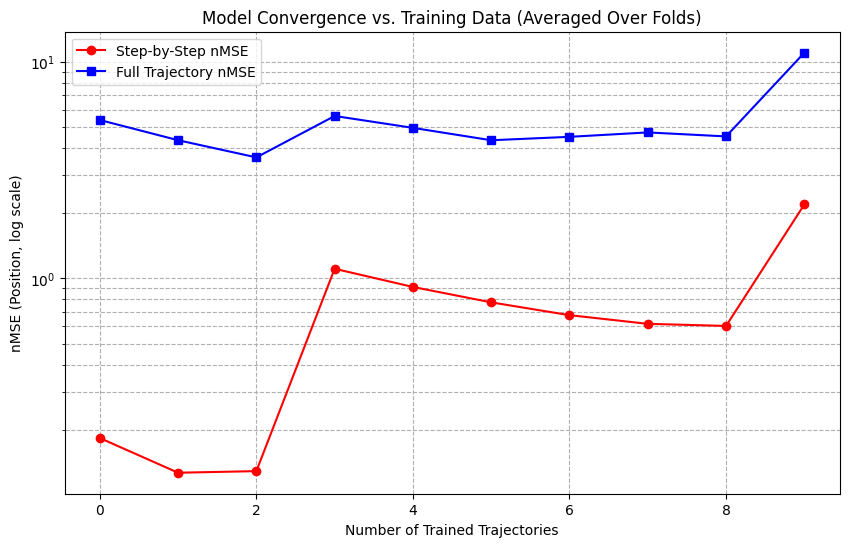

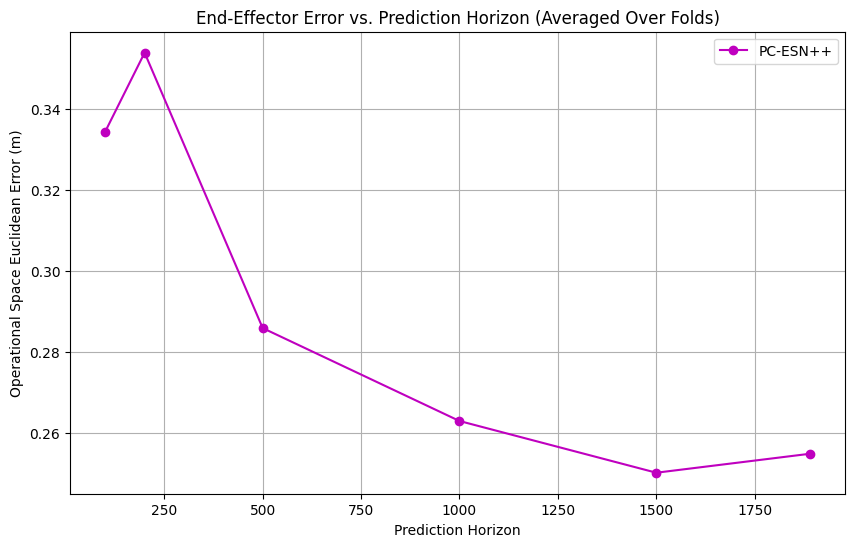

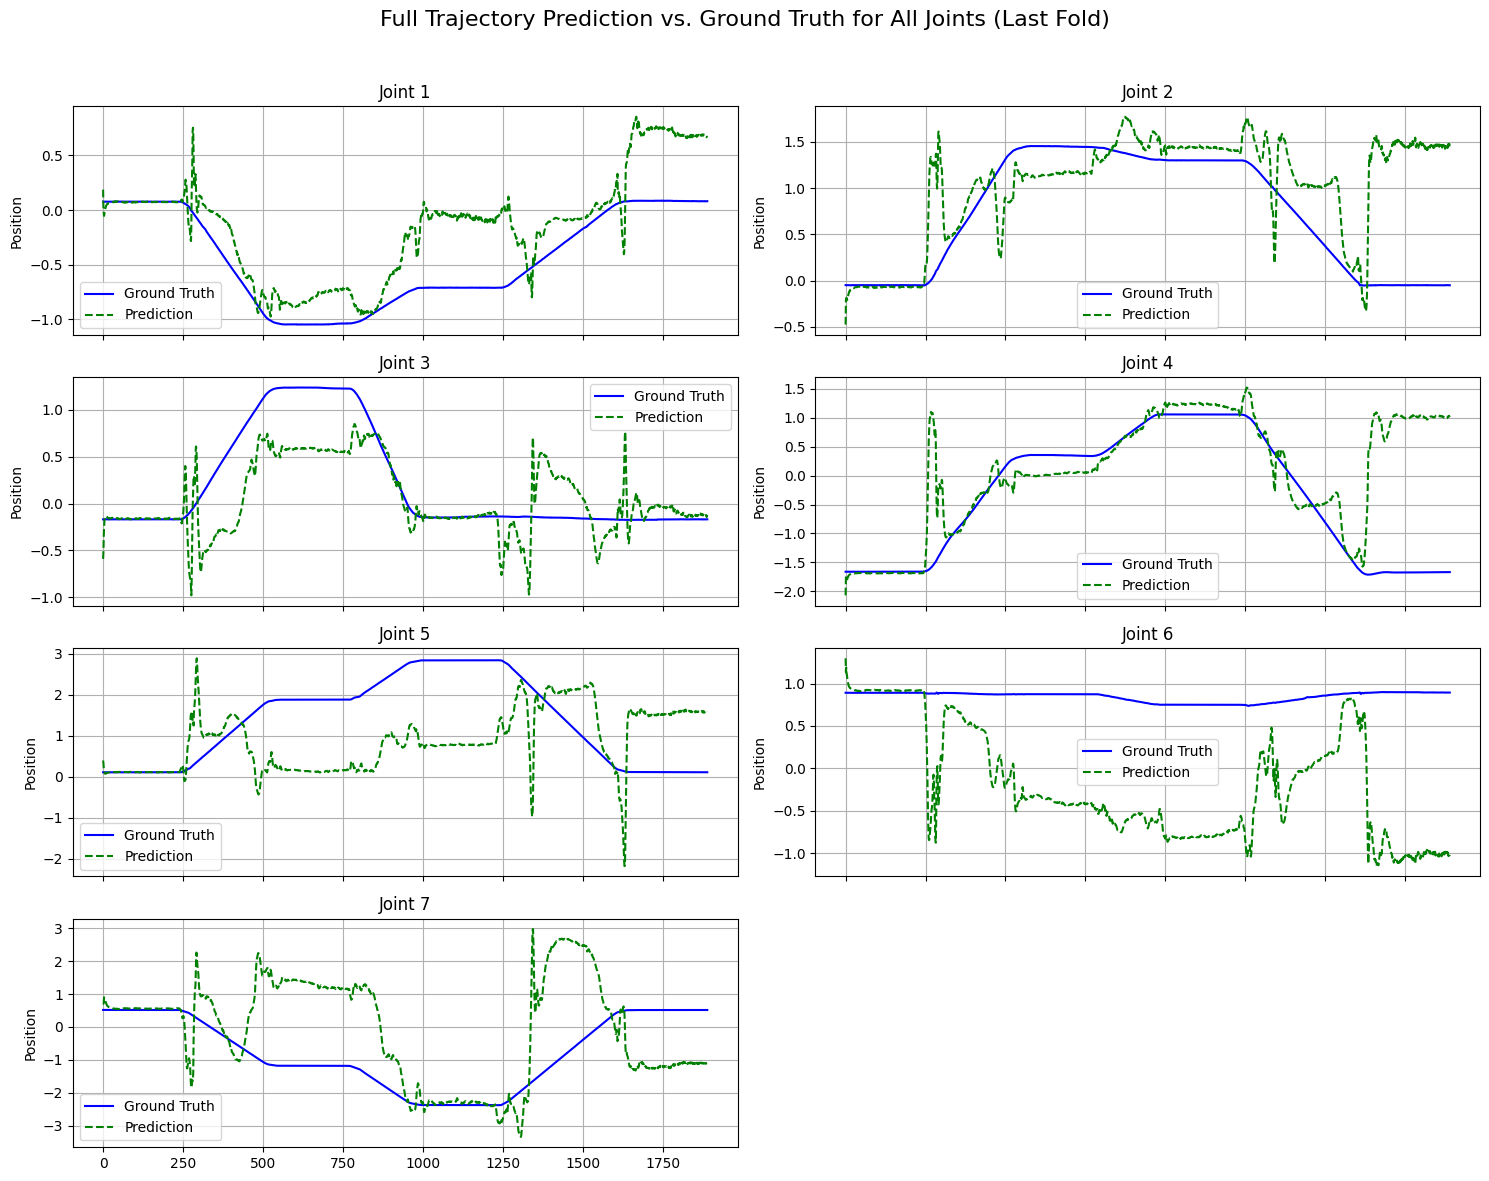

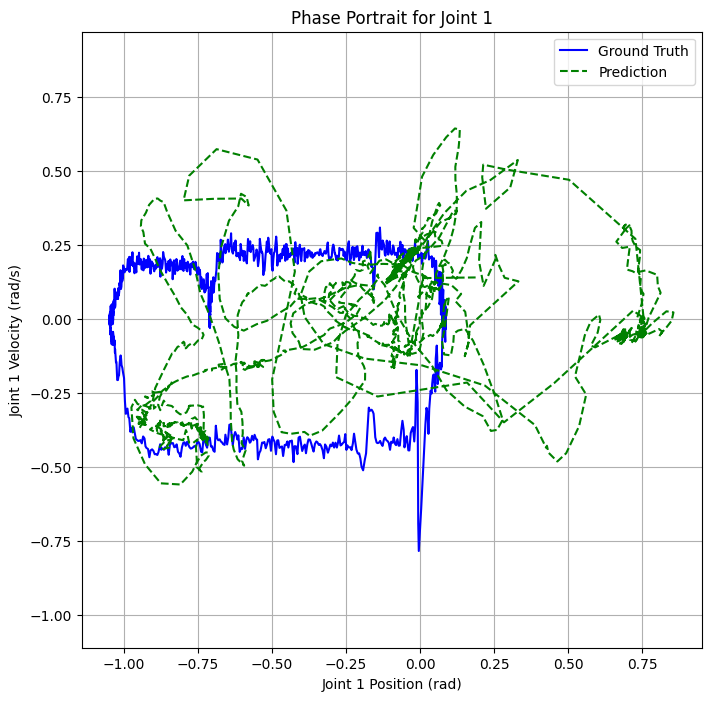

In [29]:
# --- Plot 1: Convergence Plot (Replicating Paper's Fig. 5) ---
fig1, ax1 = plt.subplots(figsize=(10, 6))
num_trajectories = np.arange(1, len(results_df) + 1)
ax1.plot(results_df['sbs_pos_nmse'].expanding().mean(), 'r-o', label='Step-by-Step nMSE')
ax1.plot(results_df['full_pos_nmse'].expanding().mean(), 'b-s', label='Full Trajectory nMSE')
ax1.set_yscale('log'); ax1.set_xlabel('Number of Trained Trajectories'); ax1.set_ylabel('nMSE (Position, log scale)')
ax1.set_title('Model Convergence vs. Training Data (Averaged Over Folds)'); ax1.legend(); ax1.grid(True, which="both", ls="--")

# --- Plot 2: Operational Space Error vs. Horizon (Replicating Paper's Fig. 6) ---
fig2, ax2 = plt.subplots(figsize=(10, 6))
horizon_cols = [f'full_euclid_err_h{h}' for h in horizons if f'full_euclid_err_h{h}' in results_df.columns]

mean_op_errors = results_df[horizon_cols].mean()
ax2.plot(horizons, mean_op_errors.values, 'm-o', label='PC-ESN++')
ax2.set_xlabel('Prediction Horizon'); ax2.set_ylabel('Operational Space Euclidean Error (m)')
ax2.set_title('End-Effector Error vs. Prediction Horizon (Averaged Over Folds)'); ax2.legend(); ax2.grid(True)

# --- Plot 3: All Joints Full Trajectory Prediction ---
fig3, axs3 = plt.subplots(4, 2, figsize=(15, 12), sharex=True)
fig3.suptitle('Full Trajectory Prediction vs. Ground Truth for All Joints (Last Fold)', fontsize=16)
axs3 = axs3.ravel()
for i in range(7):
    axs3[i].plot(last_fold_preds['true'][:, i], 'b-', label='Ground Truth')
    axs3[i].plot(last_fold_preds['full'][:, i], 'g--', label='Prediction')
    axs3[i].set_title(f'Joint {i+1}'); axs3[i].set_ylabel('Position'); axs3[i].grid(True); axs3[i].legend()
axs3[-1].set_visible(False)
plt.tight_layout(rect=[0, 0, 1, 0.96]);

# --- Plot 4: Phase Portrait for a Sample Joint (SAFEGUARD ADDED) ---
fig4, ax4 = plt.subplots(figsize=(8, 8))
joint_to_plot = 0

ax4.plot(last_fold_preds['true'][:, joint_to_plot], last_fold_preds['true'][:, joint_to_plot + 7], 'b-', label='Ground Truth')
ax4.plot(last_fold_preds['full'][:, joint_to_plot], last_fold_preds['full'][:, joint_to_plot + 7], 'g--', label='Prediction')
ax4.set_xlabel(f'Joint {joint_to_plot+1} Position (rad)'); ax4.set_ylabel(f'Joint {joint_to_plot+1} Velocity (rad/s)')
ax4.set_title(f'Phase Portrait for Joint {joint_to_plot+1}'); ax4.legend(); ax4.grid(True); ax4.axis('equal')